In [2]:
# Load necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# load the original data
df_train = pd.read_pickle("./data_frames/df_train.pkl")
df_dp_train = pd.read_pickle("./data_frames/dependency_parsing/df_dp_train.pkl")
df_dp_train.head()

,answer,answer_lemmas,answer_stop_lemmas,answer_words,answer_stop_words,answer_pos,answer_deprel,answer_root,answer_root_pos,sent_with_ans,...,q_stop_lemmas,q_words,q_stop_words,q_pos,q_deprel,q_root,q_root_pos,answer_root_word,sent_root_word,q_root_word
0,ett tillstånd för att resa in och vara i ett land,"[en, tillstånd, för, att, resa, in, och, vara,...","[tillstånd, resa, in, land]","[ett, tillstånd, för, att, resa, in, och, vara...","[tillstånd, resa, in, land]","[DET, NOUN, ADP, PART, VERB, ADV, CCONJ, AUX, ...","[det, root, mark, mark, advcl, compound:prt, c...",tillstånd,NOUN,visum är ett tillstånd för att resa in och var...,...,[visum],"[vad, är, ett, visum]",[visum],"[PRON, AUX, DET, NOUN]","[root, cop, det, nsubj]",vad,PRON,tillstånd,tillstånd,vad
1,ditt pass,"[du, pass]",[pass],"[ditt, pass]",[pass],"[PRON, NOUN]","[nmod:poss, root]",pass,NOUN,när du ska hämta ditt beslut ska du ta med dit...,...,"[skola, ta, hämta, beslut]","[vad, ska, du, ta, med, när, du, hämtar, ditt,...","[ska, ta, hämtar, beslut]","[PRON, AUX, PRON, VERB, ADP, SCONJ, PRON, VERB...","[obj, aux, nsubj, root, compound:prt, mark, ns...",ta,VERB,pass,ta,ta
2,ett år,"[en, år]",[år],"[ett, år]",[år],"[DET, NOUN]","[det, root]",år,NOUN,så länge gäller tillståndet ett uppehållstills...,...,"[länge, gälla, uppehållstillstånd, besök, länge]","[hur, länge, gäller, ett, uppehållstillstånd, ...","[länge, gäller, uppehållstillstånd, besök, län...","[ADV, ADV, VERB, DET, NOUN, ADP, NOUN, CCONJ, ...","[advmod, advmod, root, det, nsubj, case, nmod,...",gälla,VERB,år,gäller,gäller
3,ett bevis,"[en, bevis]",[bevis],"[ett, bevis]",[bevis],"[DET, NOUN]","[det, root]",bevis,NOUN,kortet är ett bevis på att du har tillstånd at...,...,[uppehållstillståndskort],"[vad, är, ett, uppehållstillståndskort]",[uppehållstillståndskort],"[PRON, AUX, DET, NOUN]","[root, cop, det, nsubj]",vad,PRON,bevis,bevis,vad
4,ett bevis,"[en, bevis]",[bevis],"[ett, bevis]",[bevis],"[DET, NOUN]","[det, root]",bevis,NOUN,kortet är ett bevis på att du har tillstånd at...,...,[uppehållstillståndskort],"[vad, är, ett, uppehållstillståndskort]",[uppehållstillståndskort],"[PRON, AUX, DET, NOUN]","[root, cop, det, nsubj]",vad,PRON,bevis,bevis,vad


In [4]:
# load the spell checked data
df_train_cleaned = pd.read_pickle("./data_frames/df_train_cleaned.pkl")
df_dp_train_cleaned = pd.read_pickle("./data_frames/dependency_parsing/df_dp_train_cleaned.pkl")
df_dp_train_cleaned.head()

,answer,answer_lemmas,answer_stop_lemmas,answer_words,answer_stop_words,answer_pos,answer_deprel,answer_root,answer_root_pos,sent_with_ans,...,q_stop_lemmas,q_words,q_stop_words,q_pos,q_deprel,q_root,q_root_pos,answer_root_word,sent_root_word,q_root_word
0,ett tillstånd för att resa in och vara i ett land,"[en, tillstånd, för, att, resa, in, och, vara,...","[tillstånd, resa, in, land]","[ett, tillstånd, för, att, resa, in, och, vara...","[tillstånd, resa, in, land]","[DET, NOUN, ADP, PART, VERB, ADV, CCONJ, AUX, ...","[det, root, mark, mark, advcl, compound:prt, c...",tillstånd,NOUN,visum är ett tillstånd för att resa in och var...,...,[visum],"[vad, är, ett, visum]",[visum],"[PRON, AUX, DET, NOUN]","[root, cop, det, nsubj]",vad,PRON,tillstånd,tillstånd,vad
1,ditt pass,"[du, pass]",[pass],"[ditt, pass]",[pass],"[PRON, NOUN]","[nmod:poss, root]",pass,NOUN,när du ska hämta ditt beslut ska du ta med dit...,...,"[skola, ta, hämta, beslut]","[vad, ska, du, ta, med, när, du, hämtar, ditt,...","[ska, ta, hämtar, beslut]","[PRON, AUX, PRON, VERB, ADP, SCONJ, PRON, VERB...","[obj, aux, nsubj, root, compound:prt, mark, ns...",ta,VERB,pass,ta,ta
2,ett år,"[en, år]",[år],"[ett, år]",[år],"[DET, NOUN]","[det, root]",år,NOUN,så länge gäller tillståndet ett uppehållstills...,...,"[länge, gälla, uppehållstillstånd, besök, länge]","[hur, länge, gäller, ett, uppehållstillstånd, ...","[länge, gäller, uppehållstillstånd, besök, län...","[ADV, ADV, VERB, DET, NOUN, ADP, NOUN, CCONJ, ...","[advmod, advmod, root, det, nsubj, case, nmod,...",gälla,VERB,år,gäller,gäller
3,ett bevis,"[en, bevis]",[bevis],"[ett, bevis]",[bevis],"[DET, NOUN]","[det, root]",bevis,NOUN,kortet är ett bevis på att du har tillstånd at...,...,[uppehållstillståndskort],"[vad, är, ett, uppehållstillståndskort]",[uppehållstillståndskort],"[PRON, AUX, DET, NOUN]","[root, cop, det, nsubj]",vad,PRON,bevis,bevis,vad
4,ett bevis,"[en, bevis]",[bevis],"[ett, bevis]",[bevis],"[DET, NOUN]","[det, root]",bevis,NOUN,kortet är ett bevis på att du har tillstånd at...,...,[uppehållstillståndskort],"[vad, är, ett, uppehållstillståndskort]",[uppehållstillståndskort],"[PRON, AUX, DET, NOUN]","[root, cop, det, nsubj]",vad,PRON,bevis,bevis,vad


In [7]:
def plot_normalized_overlap(df, title, bins, type):
    o_len = df[type+'_overlap_count'].values
    max_len = np.minimum(df[type+'_ans_wordcount'].values, df[type+'_q_wordcount'].values)
    frac_len = o_len/max_len
    # print('frac_len: ', frac_len)
    mean = np.nanmean(frac_len)
    print('mean: ', mean)
    # flat_list = [item for sublist in locations for item in sublist]
    plt.hist(frac_len)
    plt.axvline(mean, color='g', linestyle='dashed', linewidth=1, label='mean: {:.2f}'.format(mean))
    plt.ylabel('Num data points')
    plt.xlabel('Fraction of words overlapping')
    plt.legend()
    plt.title(title)
    plt.show()

In [8]:
def find_overlap_sent(a_w, q_w):
    overlap = 0
    overlap_w = []
    for w in a_w:
        if w in q_w:
            overlap += 1
            overlap_w.append(w)
    return overlap, overlap_w


In [9]:
# find overlap using the lemmatized versions of the answer sentences and questions
def find_word_overlap(df, remove_stopwords=False, use_lemmas=False):
    overlap_nr = []
    overlap_words = []
    tot_ans_words_arr = []
    tot_q_words_arr = []
    for index, row in df.iterrows():
        q_w = None
        a_w = None
        if remove_stopwords:
            if use_lemmas:
                q_w = row['q_stop_lemmas']
                a_w = row['sent_stop_lemmas']
            else: 
                q_w = row['q_stop_words']
                a_w = row['sent_stop_words']
        else:
            if use_lemmas:
                q_w = row['q_lemmas']
                a_w = row['sent_lemmas']
            else:
                q_w = row['q_words']
                a_w = row['sent_words']
        q_w = list(dict.fromkeys(q_w)) # remove duplicate words
        a_w = list(dict.fromkeys(a_w)) # remove duplicate words
        tot_ans_words_arr.append(len(a_w))
        tot_q_words_arr.append(len(q_w))
        overlap, overlap_w = find_overlap_sent(a_w, q_w)
        
        overlap_words.append(overlap_w)
        overlap_nr.append(overlap)
    
    return overlap_nr, overlap_words, tot_ans_words_arr, tot_q_words_arr


In [ ]:
# compute overlap for original data

# words with stopwords remaining
df_dp_train['word_overlap_count'], df_dp_train['word_overlap_words'], df_dp_train['word_ans_wordcount'], df_dp_train['word_q_wordcount'] = find_word_overlap(df_dp_train)
# words stopwords removed
df_dp_train['word_stop_overlap_count'], df_dp_train['word_stop_overlap_words'], df_dp_train['word_stop_ans_wordcount'], df_dp_train['word_stop_q_wordcount'] = find_word_overlap(df_dp_train, True, False)

# lemmas stopwords remaining
df_dp_train['lemma_overlap_count'], df_dp_train['lemma_overlap_words'], df_dp_train['lemma_ans_wordcount'], df_dp_train['lemma_q_wordcount'] = find_word_overlap(df_dp_train, False, True)
# lemmas stopwords removed
df_dp_train['lemma_stop_overlap_count'], df_dp_train['lemma_stop_overlap_words'], df_dp_train['lemma_stop_ans_wordcount'], df_dp_train['lemma_stop_q_wordcount'] = find_word_overlap(df_dp_train, True, True)

In [ ]:
# save df with new fields
df_dp_train.to_pickle("./data_frames/dependency_parsing/df_dp_overlap_train.pkl")

In [10]:
# compute overlap for spell checked data

# words with stopwords remaining
df_dp_train_cleaned['word_overlap_count'], df_dp_train_cleaned['word_overlap_words'], df_dp_train_cleaned['word_ans_wordcount'], df_dp_train_cleaned['word_q_wordcount'] = find_word_overlap(df_dp_train_cleaned)
# words stopwords removed
df_dp_train_cleaned['word_stop_overlap_count'], df_dp_train_cleaned['word_stop_overlap_words'], df_dp_train_cleaned['word_stop_ans_wordcount'], df_dp_train_cleaned['word_stop_q_wordcount'] = find_word_overlap(df_dp_train_cleaned, True, False)

# lemmas stopwords remaining
df_dp_train_cleaned['lemma_overlap_count'], df_dp_train_cleaned['lemma_overlap_words'], df_dp_train_cleaned['lemma_ans_wordcount'], df_dp_train_cleaned['lemma_q_wordcount'] = find_word_overlap(df_dp_train_cleaned, False, True)
# lemmas stopwords removed
df_dp_train_cleaned['lemma_stop_overlap_count'], df_dp_train_cleaned['lemma_stop_overlap_words'], df_dp_train_cleaned['lemma_stop_ans_wordcount'], df_dp_train_cleaned['lemma_stop_q_wordcount'] = find_word_overlap(df_dp_train_cleaned, True, True)

In [11]:
# save df with new fields
df_dp_train_cleaned.to_pickle("./data_frames/dependency_parsing/df_dp_overlap_train_cleaned.pkl")

mean:  0.5623722923184103


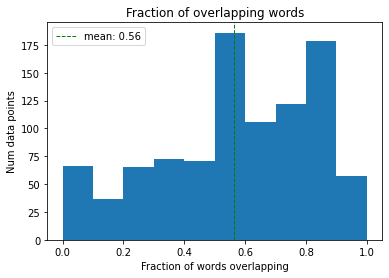

mean:  0.6354061738677123


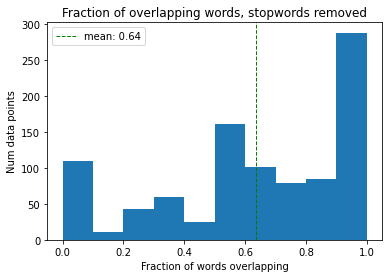

mean:  0.6118096257907627


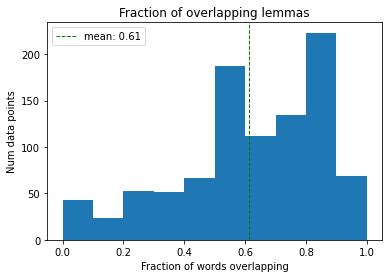

mean:  0.7061675821291206


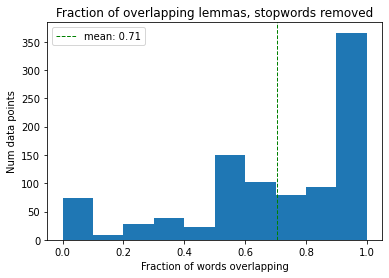

In [63]:
plot_normalized_overlap(df_dp_train, 'Fraction of overlapping words', 50, 'word')
plot_normalized_overlap(df_dp_train, 'Fraction of overlapping words, stopwords removed', 50, 'word_stop')
plot_normalized_overlap(df_dp_train, 'Fraction of overlapping lemmas', 50, 'lemma')
plot_normalized_overlap(df_dp_train, 'Fraction of overlapping lemmas, stopwords removed', 50, 'lemma_stop')

mean:  0.565592916692881


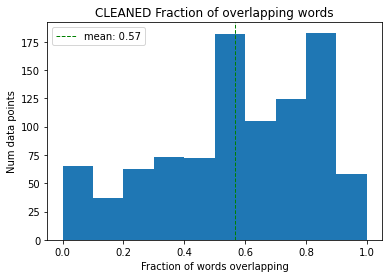

mean:  0.641488492450031


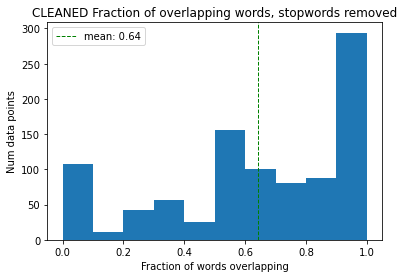

mean:  0.6156727195577025


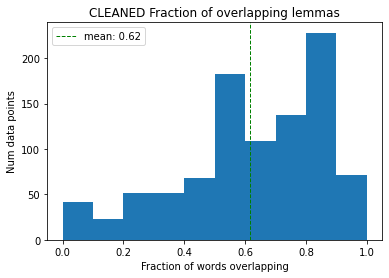

mean:  0.7136618896234281


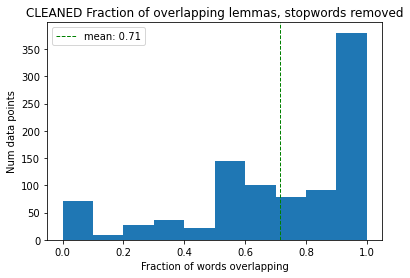

In [12]:
plot_normalized_overlap(df_dp_train_cleaned, 'CLEANED Fraction of overlapping words', 50, 'word')
plot_normalized_overlap(df_dp_train_cleaned, 'CLEANED Fraction of overlapping words, stopwords removed', 50, 'word_stop')
plot_normalized_overlap(df_dp_train_cleaned, 'CLEANED Fraction of overlapping lemmas', 50, 'lemma')
plot_normalized_overlap(df_dp_train_cleaned, 'CLEANED Fraction of overlapping lemmas, stopwords removed', 50, 'lemma_stop')

In [64]:
# find the question answer pairs where there is no / little overlap in words
def print_overlap(filename, df, type):
    with open(filename, 'w') as out:
        for index, row in df.iterrows():
            out.write('-------------------'+ '\n')
            out.write('overlapping words: ' + ' '.join(row[type+'_overlap_words']) + '\n')
            out.write('question: ' + row['question'] + '\n')
            out.write('answer: ' + row['answer'] + '\n')
            out.write('sentence with answer: '+ row['sent_with_ans']+ '\n')



df_train_little_overlap_word = df_dp_train.loc[df_dp_train['word_overlap_count'] == 0]
print('Number of Q/A pairs that have no word overlap: ', len(df_train_little_overlap_word)/len(df_train))
print_overlap('figures/question-answer-pairs-no-overlap-word.txt', df_train_little_overlap_word, 'word')

df_train_little_overlap_word_stop = df_dp_train.loc[df_dp_train['word_stop_overlap_count'] == 0]
print('Number of Q/A pairs that have no word overlap (stopwords removed): ', len(df_train_little_overlap_word_stop)/len(df_train))
print_overlap('figures/question-answer-pairs-no-overlap-word-stop.txt', df_train_little_overlap_word_stop, 'word_stop')

df_train_little_overlap_lemma = df_dp_train.loc[df_dp_train['lemma_overlap_count'] == 0]
print('Number of lemmatized Q/A pairs that have no word overlap: ', len(df_train_little_overlap_lemma)/len(df_train))
print_overlap('figures/question-answer-pairs-no-overlap-lemma.txt', df_train_little_overlap_lemma, 'lemma')

df_train_little_overlap_lemma_stop = df_dp_train.loc[df_dp_train['lemma_stop_overlap_count'] == 0]
print('Number of lemmatized Q/A pairs that have no lemma overlap (stopwords removed): ', len(df_train_little_overlap_lemma_stop)/len(df_train))
print_overlap('figures/question-answer-pairs-no-overlap-lemma-stop.txt', df_train_little_overlap_lemma_stop, 'lemma_stop')

Number of Q/A pairs that have no word overlap:  0.06548856548856549
Number of Q/A pairs that have no word overlap (stopwords removed):  0.11330561330561331
Number of lemmatized Q/A pairs that have no word overlap:  0.04261954261954262
Number of lemmatized Q/A pairs that have no lemma overlap (stopwords removed):  0.07692307692307693
